In [1]:
import tweepy
auth = tweepy.OAuthHandler("gyrMxKAb25Jl9i24oEzJoHsoK", 
    "d8FGpPREDx0GTXJZqwn3JaCmn8HkVv8W789x8d4H37RY1bCmbr")
auth.set_access_token("3229889755-WILpWosb0bvazDYazlAybKGG8msMIuLfRLXKEXy", 
    "ePwteMlE6iwGhrOWl9X26PNtXoAAYrzlApyjzEHafSWfa")
api = tweepy.API(auth)
try:
    api.verify_credentials()
    print("Authentication successful")
except:
    print("Not Authenticated")

Authentication successful


In [77]:
import pandas as pd 
tweet_data = []
#["#GreatandGood","#UVA","#UVAAlumni","#UVALaw","#UVAHealth","#UVA27","#UVAStrong","#RunWithJim","#GoHoos","#HoosNext","#UVASchoolOfMedicine"
#"#MarchMadness","#OnTheRise","#STATMadness","#UVAFacultySpotlight","#ACCMBB","#WCW","#SCOTUS","#Charlottesville"
#"#blackexcellence","#Wahoowa"]
hashtags = ["#blackexcellence"]  
for hashtag in hashtags:
    for tweet in tweepy.Cursor(api.search_tweets, q=hashtag, lang="en", tweet_mode="extended").items(1500):
        if 'retweeted_status' in dir(tweet):
            text = tweet.retweeted_status.full_text
        else:
            text = tweet.full_text
        if text not in [t['Full_Text'] for t in tweet_data]:
                tweet_data.append({
                    'User_Name': tweet.user.screen_name,
                    'Date': tweet.created_at.date(),
                    'Time': tweet.created_at.time(),
                    'Full_Text': text
                })
df = pd.DataFrame(tweet_data)
df.to_csv('UVA.csv',mode='a', index=False)
print(len(df))

521


#### Preprocessing the tweets

In [217]:
import re
import string
import nltk
from nltk.corpus import stopwords
import unicodedata
import emoji
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r'@\S+', '', text)
    text = text.replace(":", " ")
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower()
    stop_words = set(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    cleaned_text = " ".join(filtered_tokens)
    return cleaned_text

In [218]:
df = pd.read_csv("UVA.csv")
df['Preprocessed_Text'] = df['Full_Text'].apply(clean_text)
df = df.drop_duplicates(subset='Preprocessed_Text')
df = df.reset_index(drop=True)
df = df.drop('Full_Text', axis=1)
df.to_csv('UVA_cleaned_data.csv', index=False)

In [219]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
df = pd.read_csv("UVA_cleaned_data.csv")
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(df['Preprocessed_Text'])
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Preprocessed_Text'])

In [221]:
from transformers import pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
revision = "af0f99b"
model = pipeline("sentiment-analysis", model=model_name, revision=revision)
df = pd.read_csv("UVA_cleaned_data.csv")
sentiment_labels = []
for text in df['Preprocessed_Text']:
    result = model(text)[0]
    sentiment = result['label']
    if sentiment == 'POSITIVE':
        sentiment_labels.append('Positive')
    elif sentiment == 'NEGATIVE':
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')
df['Sentiment'] = sentiment_labels

In [223]:
df.to_csv("UVA_cleaned_data.csv", index=False)

In [226]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, GRU, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Bidirectional, GlobalMaxPooling1D
from tensorflow.keras import regularizers

df = pd.read_csv("UVA_cleaned_data.csv")
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Preprocessed_Text'])
sequences = tokenizer.texts_to_sequences(df['Preprocessed_Text'])

max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Sentiment'], test_size=0.2, random_state=42)

embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=64)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.3f}")
print(f"Test Accuracy: {accuracy:.3f}")


Epoch 1/15
30/30 [==============================] - 10s 105ms/step - loss: 0.7389 - accuracy: 0.6272 - val_loss: 0.7242 - val_accuracy: 0.6645
Epoch 2/15
30/30 [==============================] - 1s 50ms/step - loss: 0.7002 - accuracy: 0.6415 - val_loss: 0.6520 - val_accuracy: 0.6985
Epoch 3/15
30/30 [==============================] - 1s 50ms/step - loss: 0.6177 - accuracy: 0.7185 - val_loss: 0.5941 - val_accuracy: 0.7240
Epoch 4/15
30/30 [==============================] - 2s 52ms/step - loss: 0.5611 - accuracy: 0.7536 - val_loss: 0.5926 - val_accuracy: 0.6964
Epoch 5/15
30/30 [==============================] - 1s 50ms/step - loss: 0.5498 - accuracy: 0.7552 - val_loss: 0.5586 - val_accuracy: 0.7304
Epoch 6/15
30/30 [==============================] - 2s 51ms/step - loss: 0.5326 - accuracy: 0.7525 - val_loss: 0.5504 - val_accuracy: 0.7367
Epoch 7/15
30/30 [==============================] - 2s 51ms/step - loss: 0.5028 - accuracy: 0.7801 - val_loss: 0.5356 - val_accuracy: 0.7473
Epoch 8/15


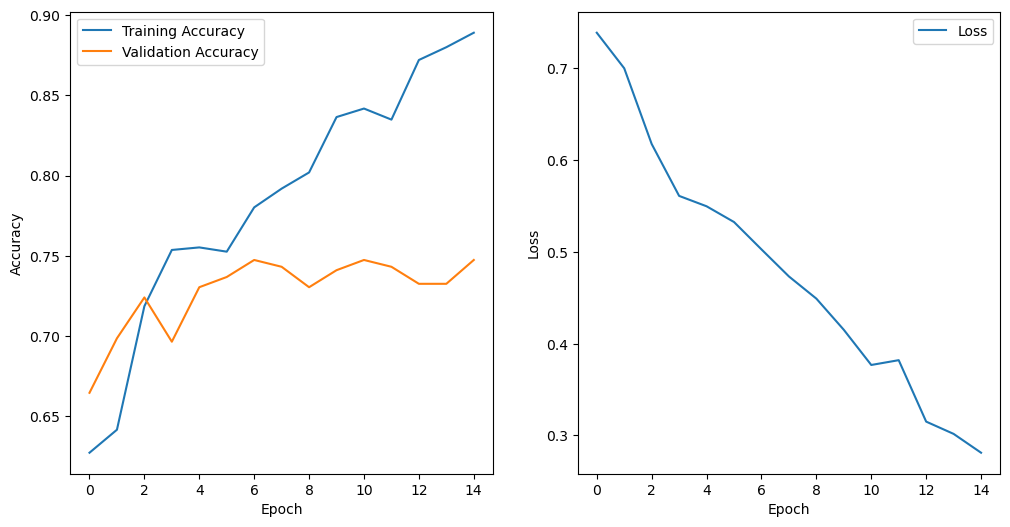

In [233]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_loss, label='Loss')
#ax2.plot(val_loss, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

<AxesSubplot:>

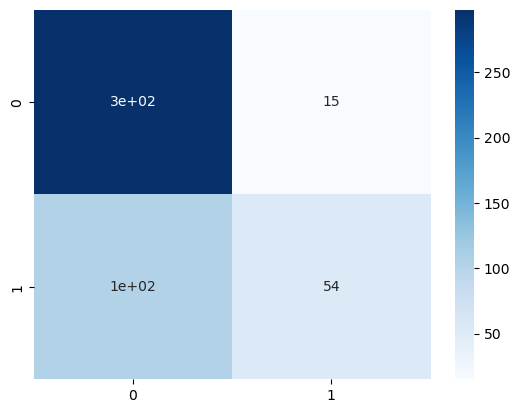

In [228]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

In [229]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       313
           1       0.78      0.34      0.48       158

    accuracy                           0.75       471
   macro avg       0.76      0.65      0.65       471
weighted avg       0.76      0.75      0.71       471



In [232]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = ['A person died due to malaria',
             'There is huge loss for family', 
             'The taste of victory was bitter as the team realized they had cheated to win.',
             'The special effects are amazing',
             'I hated the ending',
             'The characters are interesting',
             'The story is realistic', 
             'I didnt enjoy the movie',
             'The script is well-written', 
             'Students excel in exams']
sample_sequences = tokenizer.texts_to_sequences(sentences)
max_sequence_length = len(max(X_train, key=len))
sample_sequences = pad_sequences(sample_sequences, maxlen=max_sequence_length, padding='post')
predictions = model.predict(padded_sequences)
for i in range(len(sentences)):
    sentiment = 'Positive' if predictions[i] > 0.5 else 'Negative'
    print(f"Sentence: {sentences[i]}\nSentiment: {sentiment}\n")


Sentence: A person died due to malaria
Sentiment: Negative

Sentence: There is huge loss for family
Sentiment: Negative

Sentence: The taste of victory was bitter as the team realized they had cheated to win.
Sentiment: Negative

Sentence: The special effects are amazing
Sentiment: Positive

Sentence: I hated the ending
Sentiment: Negative

Sentence: The characters are interesting
Sentiment: Positive

Sentence: The story is realistic
Sentiment: Positive

Sentence: I didnt enjoy the movie
Sentiment: Negative

Sentence: The script is well-written
Sentiment: Positive

Sentence: Students excel in exams
Sentiment: Positive

